# Score-Based Timetable Prediction

## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
# For data manipulations
import pandas as pd
import os
# api for better ML
import sklearn
# Normalization functions
from sklearn.preprocessing import MinMaxScaler,QuantileTransformer,RobustScaler
from sklearn.metrics import mean_squared_error
from numpy import genfromtxt
#from numba import njit, cuda,jit 
import os

We need to import several things from Keras.

In [2]:
# Sequencial holds the box for neurons
from tensorflow.keras.models import Sequential
# The various neuron manupulation functions
from tensorflow.keras.layers import Input, Dense, GRU, Embedding, LSTM, SimpleRNN, Dropout, Bidirectional, MaxPooling1D, Conv1D, TimeDistributed, Flatten,ConvLSTM2D,RepeatVector
# These are going to adjust the weight and biases
from tensorflow.keras.optimizers import RMSprop,Adam
# EarlyStopping is a callback that ends code when there is no improvement in error(validation model: pop quiz)
# ModelCheckpoint is used to put checkpoints within the training and also saves only the best weights
# Tensorboard keeps data logs
# ReduceLROnPlateau prevents overshoots across the global mimnimum
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau
# Just for better programming
from keras.backend.tensorflow_backend import set_session


Using TensorFlow backend.


In [3]:
# Checking the GPU availabilty from tensorflow

from tensorflow import keras
from tensorflow.python.client import device_lib

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
print(device_lib.list_local_devices())

tf.config.experimental.list_physical_devices('GPU')

print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 13570203439205308339
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9427416405351648099
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 5066607840
locality {
  bus_id: 1
  links {
  }
}
incarnation: 454338882301452780
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1060, pci bus id: 0000:01:00.0, compute capability: 6.1"
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 17007105467415447532
physical_device_desc: "device: XLA_GPU device"
]
Num GPUs Available:  1


This was developed using Python 3.6 (Anaconda) and package versions:

In [4]:
tf.__version__

'2.2.0-rc3'

In [5]:
tf.keras.__version__

'2.3.0-tf'

In [6]:
pd.__version__

'1.0.3'

### Load Timetable Data



In [7]:
data_files = [ 'data_file_algebra', 'data_file_comm', 'data_file_mech']
file=f'E:\Dropbox\AI\Data_cleaning\Thing\Data\Single_courses\{data_files[0]}.csv'
#myData = pd.read_csv(file, delimiter=',')
myData = pd.read_csv(file, delimiter=',', usecols=['Program','Actual CWA','Score','Study Time','Lecturer Performance','Difficulty'
])
#figsize=(35,5)

In [8]:
myData.shape

(188, 6)

In [9]:
myData

,Program,Actual CWA,Score,Study Time,Lecturer Performance,Difficulty
0,Electrical,74.00,66.0,3.0,4,9
1,Computer,70.00,55.0,3.0,7,8
2,Electrical,68.30,55.0,2.0,1,9
3,Electrical,76.00,85.0,1.0,9,1
4,Electrical,65.00,57.0,1.0,7,5
...,...,...,...,...,...,...
183,Computer,65.00,40.0,3.5,4,10
184,Agricultural,63.67,68.0,4.5,10,5
185,Computer,56.70,54.0,0.8,6,5
186,Computer,65.00,40.0,3.5,4,10


List of the variables used in the data-set.

In [10]:
data_top = myData.columns.values
data_top

array(['Program', 'Actual CWA', 'Score', 'Study Time',
       'Lecturer Performance', 'Difficulty'], dtype=object)

These are the top rows of the data-set.

In [11]:
myData.head()

,Program,Actual CWA,Score,Study Time,Lecturer Performance,Difficulty
0,Electrical,74.0,66.0,3.0,4,9
1,Computer,70.0,55.0,3.0,7,8
2,Electrical,68.3,55.0,2.0,1,9
3,Electrical,76.0,85.0,1.0,9,1
4,Electrical,65.0,57.0,1.0,7,5


### Plotting a signal

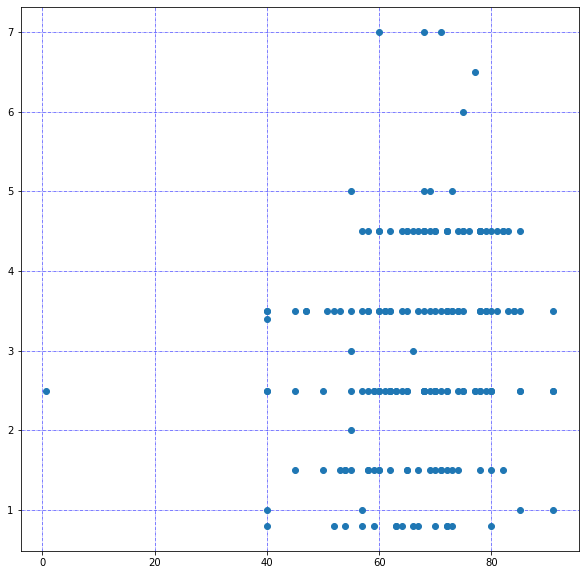

In [12]:
figsize=(10,10)
plt.figure(figsize=figsize)
plt.plot(myData['Score'],myData['Study Time'], 'o')
plt.grid(color='b', linestyle='-.', linewidth=0.5)
plt.show()

In [13]:
myData.values.shape

(188, 6)

In [15]:
myData.head(1)

,Program,Actual CWA,Score,Study Time,Lecturer Performance,Difficulty
0,Electrical,74.0,66.0,3.0,4,9


<Figure size 720x720 with 0 Axes>

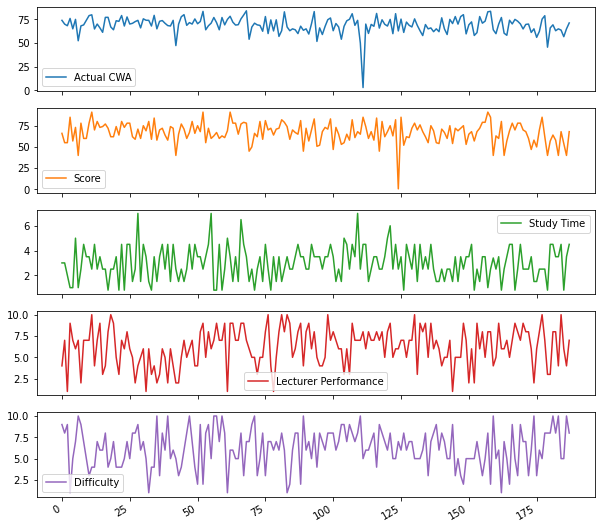

In [17]:
plt.figure(figsize=(10,10))
myData.plot(subplots=True, figsize=(10,10))
plt.show()

We can remove any signal which is deemed unimportant

In [18]:
myData.drop(( 'Program'), axis=1, inplace=True)
myData.astype('Float32')
myData.head()

,Actual CWA,Score,Study Time,Lecturer Performance,Difficulty
0,74.0,66.0,3.0,4,9
1,70.0,55.0,3.0,7,8
2,68.3,55.0,2.0,1,9
3,76.0,85.0,1.0,9,1
4,65.0,57.0,1.0,7,5


In [19]:
myData.shape

(188, 5)

### Target Data for Prediction



We will try and predict these signals.

In [20]:
target_names = ['Score']

The following is the number of time-steps that we will shift the target-data. Our data-set is resampled to have an observation for each hour, so there are 24 observations for 24 hours.

If we want to predict the weather 24 hours into the future, we shift the data 6 time-steps. If we want to predict the weather 7 days into the future, we shift the data 7 * 6 time-steps.

Create a new data-frame with the time-shifted data.

**Note the negative time-shift!**

In [21]:
df_targets = myData[target_names]
df_targets.head()

,Score
0,66.0
1,55.0
2,55.0
3,85.0
4,57.0


### NumPy Arrays

We now convert the Pandas data-frames to NumPy arrays that can be input to the neural network. We also remove the last part of the numpy arrays, because the target-data has `NaN` for the shifted period, and we only want to have valid data and we need the same array-shapes for the input- and output-data.

These are the input-signals:

In [22]:
myData

,Actual CWA,Score,Study Time,Lecturer Performance,Difficulty
0,74.00,66.0,3.0,4,9
1,70.00,55.0,3.0,7,8
2,68.30,55.0,2.0,1,9
3,76.00,85.0,1.0,9,1
4,65.00,57.0,1.0,7,5
...,...,...,...,...,...
183,65.00,40.0,3.5,4,10
184,63.67,68.0,4.5,10,5
185,56.70,54.0,0.8,6,5
186,65.00,40.0,3.5,4,10


In [23]:
myData_1=myData.copy()
myData_1.drop(( 'Score'), axis=1, inplace=True)
myData_1

,Actual CWA,Study Time,Lecturer Performance,Difficulty
0,74.00,3.0,4,9
1,70.00,3.0,7,8
2,68.30,2.0,1,9
3,76.00,1.0,9,1
4,65.00,1.0,7,5
...,...,...,...,...
183,65.00,3.5,4,10
184,63.67,4.5,10,5
185,56.70,0.8,6,5
186,65.00,3.5,4,10


In [24]:
x_data = myData_1.values
pd.DataFrame(x_data).tail()

,0,1,2,3
183,65.00,3.5,4.0,10.0
184,63.67,4.5,10.0,5.0
185,56.70,0.8,6.0,5.0
186,65.00,3.5,4.0,10.0
187,71.24,4.5,7.0,8.0


In [25]:
print(type(x_data))
print("Shape:", x_data.shape)


<class 'numpy.ndarray'>
Shape: (188, 4)


These are the output-signals (or target-signals):

In [26]:
y_data = df_targets.values
pd.DataFrame(y_data).tail()

,0
183,40.0
184,68.0
185,54.0
186,40.0
187,68.0


In [27]:
print(type(y_data))
print("Shape:", y_data.shape)

<class 'numpy.ndarray'>
Shape: (188, 1)


In [28]:
num_data = len(x_data)
num_data

188

This is the fraction of the data-set that will be used for the training-set:

In [29]:
# the dataset knows the number of features, e.g. 2
for i in range(1): print(x_data[i].shape,y_data[i].shape)

(4,) (1,)


In [30]:
train_split = 0.9

This is the number of observations in the training-set:

In [31]:
num_train = int(train_split * num_data)
num_train

169

This is the number of observations in the test-set:

In [32]:
num_test = num_data - num_train
num_test

19

These are the input-signals for the training- and test-sets:

In [33]:
x_train = x_data[0:num_train]
x_test = x_data[num_train:]
len(x_train) + len(x_test)

188

These are the output-signals for the training- and test-sets:

In [34]:
y_train = y_data[0:num_train]
y_test = y_data[num_train:]
len(y_train) + len(y_test)

188

This is the number of input-signals:

In [35]:
num_x_signals = x_data.shape[1]
num_x_signals

4

This is the number of output-signals:

In [36]:
num_y_signals = y_data.shape[1]
num_y_signals

1

### Scaled Data

The data-set contains a wide range of values:

In [37]:
print("Min:", np.min(x_train))
print("Max:", np.max(x_train))

Min: 0.8
Max: 84.07


The neural network works best on values roughly between -1 and 1, so we need to scale the data before it is being input to the neural network. We can use `scikit-learn` for this.

We first create a scaler-object for the input-signals.

In [38]:
x_scaler = MinMaxScaler()

In [39]:
x_train.shape

(169, 4)

We then detect the range of values from the training-data and scale the training-data.

In [40]:
x_train_scaled = x_scaler.fit_transform(x_train)

Apart from a small rounding-error, the data has been scaled to be between 0 and 1.

In [41]:
print("Min:", np.min(x_train_scaled))
print("Max:", np.max(x_train_scaled))

Min: 0.0
Max: 1.0000000000000002


We use the same scaler-object for the input-signals in the test-set.

<Figure size 360x360 with 0 Axes>

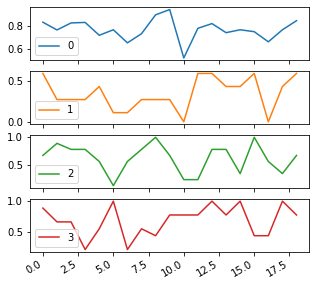

In [42]:
x_test_scaled = x_scaler.fit_transform(x_test)
plt.figure(figsize=(5,5))
pd.DataFrame(x_test_scaled).plot(subplots=True, figsize=(5,5))
plt.show()

Create a separate scaler-object for the target-data.

<Figure size 360x360 with 0 Axes>

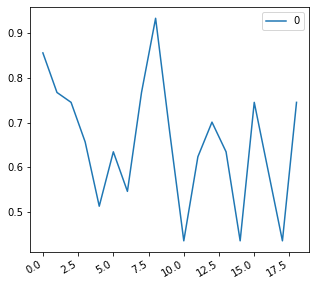

In [43]:
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.fit_transform(y_test)

plt.figure(figsize=(5,5))
pd.DataFrame(y_test_scaled).plot(subplots=True, figsize=(5,5))
plt.show()

In [44]:
print(x_train_scaled.shape)
print(y_train_scaled.shape)
print(x_test_scaled.shape)
print(y_test_scaled.shape)

(169, 4)
(169, 1)
(19, 4)
(19, 1)


Instead of training the Recurrent Neural Network on the complete sequences of almost 300k observations, we will use the following function to create a batch of shorter sub-sequences picked at random from the training-data.

## Data Generator

The data-set has now been prepared as 2-dimensional numpy arrays. The training-data has almost 2k+ observations, consisting of 11 input-signals and 11 output-signals.

These are the array-shapes of the input and output data:

In [110]:
neur = 512

We then compile the Keras model so it is ready for training.

In [111]:
# define model
# del model
#filter is also called a kernel specify
model = Sequential()
model.add(Dense(neur, input_shape=(num_x_signals,), activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
model.add(Dense(neur, activation ='relu'))
# model.add(Dropout(0.5))
#last layer is called the classification layer. We mostly use probability functions like softmax or relu for activation
model.add(Dense(num_y_signals, activation='relu'))

In [112]:
# Wrapping the black box
model.compile(loss='mean_squared_error', 
            optimizer='Adam')
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_100 (Dense)            (None, 512)               2560      
_________________________________________________________________
dense_101 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_102 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_103 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_104 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_105 (Dense)            (None, 512)               262656    
_________________________________________________________________
dense_106 (Dense)            (None, 512)              

This is a very small model with only two layers. The output shape of `(None, None, 3)` means that the model will output a batch with an arbitrary number of sequences, each of which has an arbitrary number of observations, and each observation has 3 signals. This corresponds to the 3 target signals we want to predict.

### Callback Functions

During training we want to save checkpoints and log the progress to TensorBoard so we create the appropriate callbacks for Keras.

This is the callback for writing checkpoints during training.

In [113]:
path_checkpoint = r'E:\Dropbox\AI\Data_cleaning\Thing\Model\Timetable_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)

This is the callback for stopping the optimization when performance worsens on the validation-set.

In [114]:
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=10, verbose=1)

This is the callback for writing the TensorBoard log during training.

In [115]:
callback_tensorboard = TensorBoard(log_dir=r'E:\OneDrive\AI\logs',
                                   histogram_freq=0,
                                   write_graph=False)

This callback reduces the learning-rate for the optimizer if the validation-loss has not improved since the last epoch (as indicated by `patience=0`). The learning-rate will be reduced by multiplying it with the given factor. We set a start learning-rate of 1e-3 above, so multiplying it by 0.1 gives a learning-rate of 1e-4. We don't want the learning-rate to go any lower than this.

In [120]:
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.99,
                                       min_lr=1e-9,
                                       patience=0,
                                       verbose=1)

In [121]:
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

## Train the Recurrent Neural Network

We can now train the neural network.

Note that a single "epoch" does not correspond to a single processing of the training-set, because of how the batch-generator randomly selects sub-sequences from the training-set. Instead we have selected `steps_per_epoch` so that one "epoch" is processed in a few minutes.

With these settings, each "epoch" took aa few minutes to process on a GTX 1060.

In [122]:
filepath =r'E:\Dropbox\AI\Data_cleaning\Thing\Model\Timetable_Prediction_model.h5'
def train_model(resume,fit_generator,epochs,initial_epoch,batch_size,model):
    def fit_model():
        if fit_generator:       
            print('Using fit_generator')
            history=model.fit(train_generator,
                    initial_epoch=initial_epoch,
                    epochs=epochs,
                    steps_per_epoch=steps_per_epoch,
                    validation_data=validation_generator,
                    validation_steps=50,
                    callbacks=callbacks)
            model.save(filepath)
            model.evaluate(validation_generator, steps=50)
        else:
            print('Using fit')
            history=model.fit(x_train_scaled, y_train_scaled, 
                    epochs=epochs,
                    #initial_epoch=initial_epoch,
                    verbose=1,
                    #batch_size=batch_size,
                    #steps_per_epoch=steps_per_epoch,
                    shuffle=True,
                    #validation_data=validation_data,
                    validation_split=0.2,
                    callbacks=callbacks,
                    use_multiprocessing=True,
                    workers=8)
            model.save(filepath)
            #model.evaluate(validation_data[0],validation_data[1])
        return history
    
    if resume:
        try:
            #model = load_model(filepath)
            model.load_weights(path_checkpoint)
            print(model.summary())
            print("Model loading....")
            model.evaluate(validation_generator, steps=50)
            
        except Exception as error:
            print("Error trying to load checkpoint.")
            print(error)

            
    def plot_train_history(history, title):
        loss = history.history['loss']
        val_loss = history.history['val_loss']
        epochs = range(len(loss))
        plt.figure(figsize=(15,5))
        plt.plot(epochs, loss, 'b', label='Training loss')
        plt.plot(epochs, val_loss, 'r', label='Validation loss')
        plt.title(title)
        plt.legend()
        plt.show()
        
    # Training the Model
    history = fit_model()
    plot_train_history(history, 'Model Training History ')
    return

Using fit
Epoch 1/1000
2/5 [===========>..................] - ETA: 0s - loss: 0.4504WARNING:tensorflow:Method (on_train_batch_end) is slow compared to the batch update (0.309041). Check your callbacks.

Epoch 00001: val_loss did not improve from 0.31703
5/5 [==============================] - 1s 174ms/step - loss: 0.4628 - val_loss: 0.4830 - lr: 1.0000e-06
Epoch 2/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.4404
Epoch 00002: val_loss did not improve from 0.31703
5/5 [==============================] - 0s 63ms/step - loss: 0.4533 - val_loss: 0.4827 - lr: 1.0000e-06
Epoch 3/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.4426
Epoch 00003: val_loss did not improve from 0.31703
5/5 [==============================] - 0s 23ms/step - loss: 0.4587 - val_loss: 0.4824 - lr: 1.0000e-06
Epoch 4/1000
1/5 [=====>........................] - ETA: 0s - loss: 0.4634
Epoch 00004: val_loss did not improve from 0.31703
5/5 [==============================] - 0s 25ms/step - loss

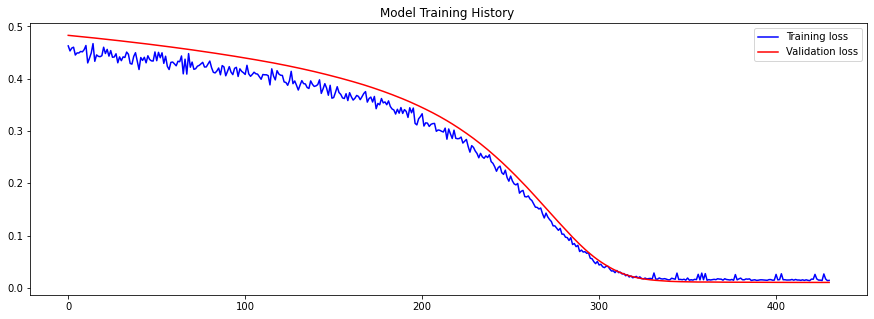

In [123]:
EPOCHS=1000
batch_size=20
#steps_per_epoch = int((num_train/batch_size)/2)
#steps_per_epoch=256

train_model(resume=False, fit_generator=False, epochs=EPOCHS, initial_epoch=0, batch_size=batch_size, model=model)

%%time
#try:
#    model.load_weights(path_checkpoint)
#except Exception as error:
    #print("Error trying to load checkpoint.")
    #print(error)

for _ in range(10):
    batch_size = np.random.randint(250)
    model.fit(generator,
                    epochs=4,
                    steps_per_epoch=batch_size,
                    batch_size=batch_size,
                    validation_data=validation_data,
                    callbacks=callbacks)
    result = model.evaluate(x=validation_data[0], y=validation_data[1])
    if result<=0.00041:
        break

### Load Checkpoint

Because we use early-stopping when training the model, it is possible that the model's performance has worsened on the test-set for several epochs before training was stopped. We therefore reload the last saved checkpoint, which should have the best performance on the test-set.

In [124]:
try:
    model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

## Performance on Test-Set

We can now evaluate the model's performance on the test-set. This function expects a batch of data, but we will just use one long time-series for the test-set, so we just expand the array-dimensionality to create a batch with that one sequence.

In [125]:
result = model.evaluate(x_test_scaled,y_test_scaled)


1/1 [==============================] - 0s 2ms/step - loss: 0.0197


In [126]:
print("loss (test-set):", result)

loss (test-set): 0.019671950489282608


In [127]:
# If you have several metrics you can use this instead.
if False:
    for res, metric in zip(result, model.metrics_names):
        print("{0}: {1:.3e}".format(metric, res))

## Generate Predictions

This helper-function plots the predicted and true output-signals.

In [128]:
y_predict = model.predict(x_test_scaled, verbose=0)
y_predict = y_scaler.inverse_transform(y_predict)
print('Model Output:', y_predict)
print('Difference:', y_scaler.inverse_transform(y_test_scaled)-y_predict)

Model Output: [[72.99503 ]
 [69.79742 ]
 [69.26444 ]
 [66.68957 ]
 [64.74388 ]
 [64.31577 ]
 [58.557243]
 [66.59733 ]
 [72.50849 ]
 [70.972664]
 [57.117764]
 [66.44183 ]
 [75.37403 ]
 [70.074   ]
 [68.05224 ]
 [72.75919 ]
 [59.65115 ]
 [68.05224 ]
 [72.141045]]
Difference: [[  5.00496674]
 [  0.20258331]
 [ -1.26444244]
 [ -6.68956757]
 [-17.74388123]
 [ -6.31577301]
 [ -8.55724335]
 [  3.40267181]
 [ 12.49150848]
 [ -8.97266388]
 [-17.11776352]
 [ -9.4418335 ]
 [-11.37403107]
 [-12.0739975 ]
 [-28.05223846]
 [ -4.75919342]
 [ -5.65114975]
 [-28.05223846]
 [ -4.14104462]]


In [82]:
x, y = next(train_generator)
x[0].shape
x_scaler.inverse_transform(x[0]).shape

NameError: name 'train_generator' is not defined

In [ ]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x, y_true = next(train_generator)
        x, y_true = x[0], y_true[0]
        y_signal = x_scaler.inverse_transform(x)[:,:num_y_signals]
        y_true = y_scaler.inverse_transform(y_true)[:,:num_y_signals]
        
    else:
        # Use test-data.
        print('Using test data')
        x, y_true = next(validation_generator)
        x, y_true = x[0], y_true[0]
        y_signal = x_scaler.inverse_transform(x)[:,:num_y_signals]
        y_true = y_scaler.inverse_transform(y_true)[:,:num_y_signals]
        
    print(x.shape)      
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    #for signal in range(len(target_names)):
    for signal in range(num_y_signals):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]
        
        # Get the input-signals used for prediction.
        #y_signal = y_signal[warmup_steps:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(35,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        #plt.plot(y_signal, label='input')
        

        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.grid(color='b', linestyle='-.', linewidth=0.15)
        plt.legend()
        plt.show()

    return y_pred_rescaled, y_true, y_signal

In [ ]:
look_back=-sequence_length+20

plot_comparison(start_idx=-look_back, length=look_back-1, train=True)

We can now plot an example of predicted output-signals. It is important to understand what these plots show, as they are actually a bit more complicated than you might think.

These plots only show the output-signals and not the 336 input-signals used to predict the output-signals. The time-shift between the input-signals and the output-signals is held fixed in these plots. The model **always** predicts the output-signals e.g. 24 hours into the future (as defined in the `shift_steps` variable above). So the plot's x-axis merely shows how many time-steps of the input-signals have been seen by the predictive model so far.

The prediction is not very accurate for the first 30-50 time-steps because the model has seen very little input-data at this point.
The model generates a single time-step of output data for each time-step of the input-data, so when the model has only run for a few time-steps, it knows very little of the history of the input-signals and cannot make an accurate prediction. The model needs to "warm up" by processing perhaps 30-50 time-steps before its predicted output-signals can be used.

That is why we ignore this "warmup-period" of 50 time-steps when calculating the mean-squared-error in the loss-function. The "warmup-period" is shown as a grey box in these plots.

Let us start with an example from the training-data. This is data that the model has seen during training so it should perform reasonably well on this data.

In [ ]:
signal_pred0, signal_true0, y_signal0 = plot_comparison(start_idx=look_back, length=np.abs(look_back+1), train=False)

In [ ]:
signal_pred0.shape

In [ ]:
pd.concat([pd.DataFrame(signal_true0[:,2]),pd.DataFrame(signal_pred0[:,2]),pd.DataFrame(y_signal0[:,2])])#.plot(figsize=(35,5), subplots=False)

In [ ]:
pd.DataFrame(signal_pred0).tail(65)

In [11]:
pd.DataFrame(signal_true0).tail(65)

NameError: name 'pd' is not defined

In [12]:
yPred = pd.DataFrame(signal_pred0).values[:-shift_steps]
print(yPred.shape)
pd.DataFrame(yPred).tail(10)

NameError: name 'pd' is not defined

In [13]:
yTrue = pd.DataFrame(signal_true0).shift(2*shift_steps).values[shift_steps:]
print(yTrue.shape)
pd.DataFrame(yTrue).tail(10)

NameError: name 'pd' is not defined

In [14]:
for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = yPred[warmup_steps:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = yTrue[warmup_steps:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(35,10))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.grid(color='b', linestyle='-.', linewidth=0.15)
        plt.legend()
        plt.show()


NameError: name 'target_names' is not defined

In [15]:
x_data = myData.values
print(x_data.shape)
x_scaler=QuantileTransformer()
x_data_scaled=x_scaler.fit_transform(x_data)
print(x_data_scaled.min(),x_data_scaled.max(),x_data_scaled.shape)
y_data = x_data[:,:4]
y_scaler=QuantileTransformer()
y_data_scaled=y_scaler.fit_transform(y_data)
print(y_data_scaled.min(),y_data_scaled.max(),y_data_scaled.shape)
#x_data_rescaled = x_scaler.inverse_transform(x_data_scaled)
#plt.plot(x_data_rescaled[:,1])

NameError: name 'myData' is not defined

In [18]:
def plot_forecast(look_back, x_data=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if x_data:
        # Use training-data.
        x = x_data_scaled[-look_back:]
        num_x = x.shape[1]
        y_true = x_scaler.inverse_transform(x)[:,:4]
        x = np.expand_dims(x, axis=0)
        print('x_input.shape:',x.shape)
        print('y_true.shape:',y_true.shape)
    else:
        print('No data input to model')
   
   
    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    #print(y_pred.shape)
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    print('y_pred_rescaled: ',y_pred_rescaled.shape)
    # For each output-signal.
    for signal in range(len(target_names)):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[warmup_steps:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[warmup_steps:, signal]
        
        # Make the plotting-canvas bigger.
        plt.figure(figsize=(35,10))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(target_names[signal])
        plt.grid(color='b', linestyle='-.', linewidth=0.15)
        plt.legend()
        plt.show()

    return y_pred_rescaled

In [20]:
future_steps=shift_steps
look_back=sequence_length
x_pred_rescaled=plot_forecast(look_back=look_back, x_data=True)
print(x_pred_rescaled.shape)

NameError: name 'shift_steps' is not defined

The model was able to predict the overall oscillations of the temperature quite well but the peaks were sometimes inaccurate. For the wind-speed, the overall oscillations are predicted reasonably well but the peaks are quite inaccurate. For the atmospheric pressure, the overall curve-shape has been predicted although there seems to be a slight lag and the predicted curve has a lot of noise compared to the smoothness of the original signal.

plot_comparison(start_idx=-look_back, length=look_back-1, train=True)

As a check, we can plot this signal directly from the resampled data-set, which looks similar.

We can plot the same period from the original data that has not been resampled. It also looks similar.

So either the temperature was unusually stable for a part of this period, or there is a data-error in the raw data that was obtained from the internet weather-database.

In [23]:
from pandas.tseries.offsets import DateOffset
add_dates = [myData.index[-1] + DateOffset(hours=4*x) for x in range(0,shift_steps+1) ]
future_dates = pd.DataFrame(index=add_dates[1:],columns=myData.columns)

NameError: name 'shift_steps' is not defined

In [26]:
df_predict = pd.DataFrame(x_pred_rescaled[-shift_steps:],
                          index=future_dates[-shift_steps:].index, columns=list(myData.columns.values))

df_predict=pd.DataFrame(df_predict)
df_predict

NameError: name 'x_pred_rescaled' is not defined

In [29]:
df_predict.index.name='datetime'
df_predict
myData.tail(1)

NameError: name 'df_predict' is not defined

Address1=r'C:\Users\hp\Desktop\myData.csv'
Address2=r'C:\Users\hp\Desktop\df_pred.csv'
Address3=r'C:\Users\hp\Desktop\output.csv'
os.rmdir(Address1)
os.rmdir(Address2)
os.rmdir(Address3)

In [32]:
pd.DataFrame(myData).to_csv(r'C:\Users\hp\Desktop\myData.csv')
pd.DataFrame(df_predict).to_csv(r'C:\Users\hp\Desktop\df_pred.csv')

NameError: name 'df_predict' is not defined

In [ ]:
a = pd.read_csv(r'C:\Users\hp\Desktop\myData.csv',header=None)
b = pd.read_csv(r'C:\Users\hp\Desktop\df_pred.csv',header=None)
b = b.dropna(axis=0)
merged = pd.concat([a, b])
merged.to_csv(r'C:\Users\hp\Desktop\output.csv', index=None, header=None)
df_proj = pd.read_csv(r'C:\Users\hp\Desktop\output.csv',delimiter=',',low_memory=False)#index_col=[0], parse_dates=True)

df_proj = df_proj.set_index('datetime')
df_proj=(df_proj.assign(datetime=lambda df_proj: pd.to_datetime(df_proj.index))
         .set_index('datetime'))
#type(df_proj.index)
df_proj.tail(future_steps)

## Univariate Vanilla LSTM example

In [37]:
# univariate lstm example
from numpy import array
 
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.23133]]


## Univariate stacked lstm example

In [39]:
from numpy import array
 
# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.75422]]


## Univariate Bidirectional lstm example

In [41]:

# split a univariate sequence
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 3
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
model = Sequential()
model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[102.50265]]


## Univariate CNN lstm example

In [43]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, subsequences, timesteps, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, n_steps, n_features))
# define model
model = Sequential()
model.add(TimeDistributed(Conv1D(filters=64, kernel_size=1, activation='relu'), input_shape=(None, n_steps, n_features)))
model.add(TimeDistributed(MaxPooling1D(pool_size=2)))
model.add(TimeDistributed(Flatten()))
model.add(LSTM(50, activation='relu'))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[100.93751]]


## Univariate ConvLSTM example

In [ ]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the sequence
		if end_ix > len(sequence)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)
 
# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps = 4
# split into samples
X, y = split_sequence(raw_seq, n_steps)
# reshape from [samples, timesteps] into [samples, timesteps, rows, columns, features]
n_features = 1
n_seq = 2
n_steps = 2
X = X.reshape((X.shape[0], n_seq, 1, n_steps, n_features))
# define model
model = Sequential()
model.add(ConvLSTM2D(filters=64, kernel_size=(1,2), activation='relu', input_shape=(n_seq, 1, n_steps, n_features)))
model.add(Flatten())
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=500, verbose=0)
# demonstrate prediction
x_input = array([60, 70, 80, 90])
x_input = x_input.reshape((1, n_seq, 1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

# Multivariate LSTM Models

## Multivariate lstm example

In [46]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :-1], sequences[end_ix-1, -1]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(50, activation='relu', input_shape=(n_steps, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=0)
# demonstrate prediction
x_input = array([[80, 85], [90, 95], [100, 105]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

NameError: name 'hstack' is not defined

## Multivariate output stacked lstm example

In [ ]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps
		# check if we are beyond the dataset
		if end_ix > len(sequences)-1:
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
# choose a number of time steps
n_steps = 3
# convert into input/output
X, y = split_sequences(dataset, n_steps)
# the dataset knows the number of features, e.g. 2
n_features = X.shape[2]
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
model.add(LSTM(100, activation='relu'))
model.add(Dense(n_features))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=400, verbose=0)
# demonstrate prediction
x_input = array([[70,75,145], [80,85,165], [90,95,185]])
x_input = x_input.reshape((1, n_steps, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

# Multi-Step LSTM Models

## Univariate multi-step vector-output stacked lstm example

In [293]:
from numpy import array
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 5
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
print(x.shape,y.shape)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
# define model
#model = Sequential()
#model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps_in, n_features)))
##model.add(LSTM(100, activation='relu'))
#model.add(Dense(n_steps_out))
#model.compile(optimizer='adam', loss='mse')
# fit model
#model.fit(X, y, epochs=50, verbose=0)
# demonstrate prediction
#x_input = array([70, 80, 90])
#x_input = x_input.reshape((1, n_steps_in, n_features))
#yhat = model.predict(x_input, verbose=0)
#print(yhat)

(336, 4) (2, 5)


# Univariate multi-step encoder-decoder lstm example

In [52]:
# split a univariate sequence into samples
def split_sequence(sequence, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequence)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the sequence
		if out_end_ix > len(sequence):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequence[i:end_ix], sequence[end_ix:out_end_ix]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
raw_seq = [10, 20, 30, 40, 50, 60, 70, 80, 90]
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# split into samples
X, y = split_sequence(raw_seq, n_steps_in, n_steps_out)
# reshape from [samples, timesteps] into [samples, timesteps, features]
n_features = 1
X = X.reshape((X.shape[0], X.shape[1], n_features))
y = y.reshape((y.shape[0], y.shape[1], n_features))
# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(100, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(1)))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=100, verbose=0)
# demonstrate prediction
x_input = array([70, 80, 90])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

[[[ 97.31378 ]
  [109.932556]]]


# Multivariate Multi-Step LSTM Models

## Multiple Input Multi-Step Output

## Multivariate multi-step stacked lstm example

In [337]:
print(myData.values[:num_train].shape,
myData.values[num_train:].shape,
myData.values.shape)

(31040, 4) (3449, 4) (34489, 4)


In [350]:
from numpy import array
from numpy import hstack
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense

# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out-1
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix-1,:], sequences[end_ix-1:out_end_ix, :4]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y).reshape(len(y),4)


# choose a number of time steps
n_steps_in, n_steps_out = 336, 1

# covert into input/output
X, y = split_sequences(myData.values[:num_train], n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
n_steps_in=n_steps_in-1
n_features = X.shape[2]
print(X.shape,y.shape)
#pd.DataFrame(np.vstack([X[0],y[0]])).tail(10)
print(X[0],y[0])
# define model
#del model
model = Sequential()
model.add(LSTM(768, activation='selu', return_sequences=True, input_shape=(n_steps_in, n_features)))
model.add(LSTM(768, activation='selu'))
model.add(Dense(4, activation='selu'))
model.compile(optimizer='adam', loss='mse')
# fit model
model.fit(X, y, epochs=200, verbose=1)
# demonstrate prediction
x_input,y_output = split_sequences(myData.values[num_train:], n_steps_in+1, n_steps_out)
x_input[0].shape,y_output[0].shape
print(x_input[0],y_output[0])
print(myData.values[num_train:num_train+n_steps_in+1])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=1)
print(yhat)

(30705, 335, 4) (30705, 4)
[[1.2734 1.2755 1.2723 1.273 ]
 [1.273  1.2789 1.273  1.2778]
 [1.2778 1.281  1.2775 1.2805]
 ...
 [1.3452 1.3462 1.342  1.3448]
 [1.3438 1.3487 1.3432 1.3465]
 [1.3455 1.3522 1.3455 1.351 ]] [1.3506 1.3548 1.3498 1.3548]
Epoch 1/200
  416/30705 [..............................] - ETA: 51:51 - loss: 2.4792

KeyboardInterrupt: 

## Multivariate multi-step encoder-decoder lstm example

In [55]:
# split a multivariate sequence into samples
def split_sequences(sequences, n_steps_in, n_steps_out):
	X, y = list(), list()
	for i in range(len(sequences)):
		# find the end of this pattern
		end_ix = i + n_steps_in
		out_end_ix = end_ix + n_steps_out
		# check if we are beyond the dataset
		if out_end_ix > len(sequences):
			break
		# gather input and output parts of the pattern
		seq_x, seq_y = sequences[i:end_ix, :], sequences[end_ix:out_end_ix, :]
		X.append(seq_x)
		y.append(seq_y)
	return array(X), array(y)

# define input sequence
in_seq1 = array([10, 20, 30, 40, 50, 60, 70, 80, 90])
in_seq2 = array([15, 25, 35, 45, 55, 65, 75, 85, 95])
out_seq = array([in_seq1[i]+in_seq2[i] for i in range(len(in_seq1))])
# convert to [rows, columns] structure
in_seq1 = in_seq1.reshape((len(in_seq1), 1))
in_seq2 = in_seq2.reshape((len(in_seq2), 1))
out_seq = out_seq.reshape((len(out_seq), 1))
# horizontally stack columns
dataset = hstack((in_seq1, in_seq2, out_seq))
print(dataset)
# choose a number of time steps
n_steps_in, n_steps_out = 3, 2
# covert into input/output
X, y = split_sequences(dataset, n_steps_in, n_steps_out)
# the dataset knows the number of features, e.g. 2
for i in range(len(y)): print(X[i],y[i])
n_features = X.shape[2]
print(X.shape)
# define model
model = Sequential()
model.add(LSTM(200, activation='relu', input_shape=(n_steps_in, n_features)))
model.add(RepeatVector(n_steps_out))
model.add(LSTM(200, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(n_features)))
model.compile(optimizer='adam', loss='mse')
# fit model
#model.fit(X, y, epochs=300, verbose=0)
# demonstrate prediction
x_input = array([[60, 65, 125], [70, 75, 145], [80, 85, 165]])
x_input = x_input.reshape((1, n_steps_in, n_features))
yhat = model.predict(x_input, verbose=0)
print(yhat)

NameError: name 'hstack' is not defined